In [ ]:
# those are the parameters passed to the notebook
#TIME_RESOLUTION = pm.parameter("TIME_RESOLUTION") # Could be 1H, 2H, 6, 24H | Important: Must be string
#SPATIAL_RESOLUTION = pm.parameter("SPATIAL_RESOLUTION")
#OUTPUT_FILENAME_BASE = pm.parameter("OUTPUT_FILENAME_BASE")

# Predictive Analytics with SVM and Neural Networks

Task:

build prediction models that predict taxi trip demand using a) support vector machines and b) neural
networks (deep learning) in spatio-temporal resolution (i.e., spatial-unit and time buckets). In other
words, your method should predict for each spatial unit (hexagon and census tract) and time-basket
(e.g., 08am-11.59am) the taxi demand. Also adevise a reasonable validation strategy for your prediction
model (i.e., definition of test, training data etc).

Approach for SVM:
– Simply start without a kernel. Then, gradually make your model complex by integrating different
kind of kernels. Also, use grid search to find optimal values for your hyperparameters.
– How good is your model? Evaluate your model’s performance and comment on its shortfalls.
– Show how you model’s performance varies as you increase or decrease temporal resolution for the
following period length: 1h, 2h, 6h, 24h. Also, vary the length of the hexagon edges. How does your
performance change when you only use census tract as spatial units?
– How could the model be improved further? Explain some of the improvement levers that you might
focus on in a follow-up project.
 Approach for Deep Learning:
– Repeat the steps from subtask 4a), but this time use a feedforward neural network.
– Is the performance very different from the previous approach?
– With this realization, do you think it is worth to employ a deep-learning approach?

## General Approach Draft

We will Support Vector Regression (SVR) to predict future demand. It is a machine learning algorithm used for regression tasks, which involve predicting a continuous target variable. SVR builds upon the concept of Support Vector Machines (SVM) and aims to find a hyperplane that best fits the data while minimizing the margin violations. In SVR, the goal is to find a hyperplane that maximizes the margin around the predicted values, while allowing a tolerance for some errors. It uses a kernel function to map the data into a higher-dimensional space, allowing it to capture nonlinear relationships. SVR is particularly useful for handling complex data and can handle both linear and nonlinear regression tasks effectively.

The general model architecture will be as follows: 
- Predict one 1-hour intervals for the smallest resolution
- dynamically upscale

### Implementation Plan
1. Fix missing census data (done)
2. Remove start census without any values as the are not in city limits (done)
3. create two datasets, one with h3 clustering (h=7 or 6) and census (done)
4. (optional, if time) add POI data score to each spatial dimension (3/4 done)
5. apply temporal features (done)

Dataset is done

6. Build ensemble model
7. Training Loop and Training dataset (done)
8. Train Models and hyperparameter tuning


## Feature Engineering & Import of Missing data
First, we will start by fixing the missing census data. After that, we will remove all records for which we can not find a start location in the census data locations, as the can not be counted as demand in the census data tract. We will then create two datasets, one for the census-based model and one for the h3 based model. On both datasets, we might choose to enrich our collected h3 data, but this is based on remaining time. With the two datasets in place, we will add temporal features, such as demand lag (the demand on h-1, h-24 hours etc) as well as weekend, seasonal and weather features.


In [8]:
# Imports
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import h3
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import papermill as pm

In [10]:
# edited trip dataframe
BASE_H3_DATASET_ON_CENSUS_DATASET = True
df_taxi = pd.read_csv('data/prepared/taxi_weather.csv')

### Spatial Feature Engineering
First, we will start by fixing the missing census data. For this, we will grab a geojson dataset of the 2010 Census tract boundaries from here https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Tracts-2010/5jrd-6zik. To the best of our knowledge, this is the latest data for the census tract. 

We will then fill the 'pickup_census_tract' value of each dataentry that has no value in this column with the appropriate value by mapping the pick longitude and latitude on the census tract geojson data. From this, we will fill all columns of entries that started within a cencus tract. We will then drop all other values, as they didn't originate from a cencus tract and are therefore not relevant for the demand (i.e. the number of pickups in a certain area at a certain time).

We will then create an additional dataset and group the entries by h3 index. From both h3 and census tract, we will remove the info about the other spatial units to keep them small. Afterwards, we can start with adding the temporal features.

#### Fixing missing Census Tract Info

In [11]:
df_taxi.head()

,trip_id,taxi_id,start_time,end_time,minutes,miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,temperature,wind_speed,precip,condition
0,bcfa19f2539021c054809d4c3993d226996ae095,368ce5511598af2cc07efdb68067d381174fdac1d47a28...,2022-01-01 00:00:00,2022-01-01 00:00:00,2.53,0.10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,33,21.0,0.0,Light Snow / Windy
1,2aba69ff015f9ea8e7bff43cab7eddb228f34a12,449fa4909552757130d09d98ebc7770e2dd94579036b0e...,2022-01-01 00:00:00,2022-01-01 00:30:00,39.33,17.44,NaN,NaN,NaN,8.0,...,NaN,NaN,NaN,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),33,21.0,0.0,Light Snow / Windy
2,54d812a0b88f8f9707825261014b3563a0a60ace,f98ae5e71fdda8806710af321dce58002146886c013f41...,2022-01-01 00:00:00,2022-01-01 00:00:00,8.93,4.83,NaN,NaN,28.0,22.0,...,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.922761,-87.699155,POINT (-87.6991553432 41.9227606205),33,21.0,0.0,Light Snow / Windy
3,040caea96573c5743668b138011bc157c7825e86,b9a58663518c48b09e83f462ca25ee0d702a2e4bc12199...,2022-01-01 00:00:00,2022-01-01 00:15:00,20.93,13.29,NaN,NaN,76.0,NaN,...,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),NaN,NaN,NaN,33,21.0,0.0,Light Snow / Windy
4,0f0c856e620e6b4dfd2bb1e921d966dd179eeca1,b21050ab3ad3d0972fd6378f6bf4d0251a8a7af42e6e0e...,2022-01-01 00:00:00,2022-01-01 00:00:00,0.55,0.17,NaN,NaN,3.0,3.0,...,41.965812,-87.655879,POINT (-87.6558787862 41.96581197),41.965812,-87.655879,POINT (-87.6558787862 41.96581197),33,21.0,0.0,Light Snow / Windy


maps all trips into census spatial system. For this, we first import the geojson boundary of the census tracts of chicago

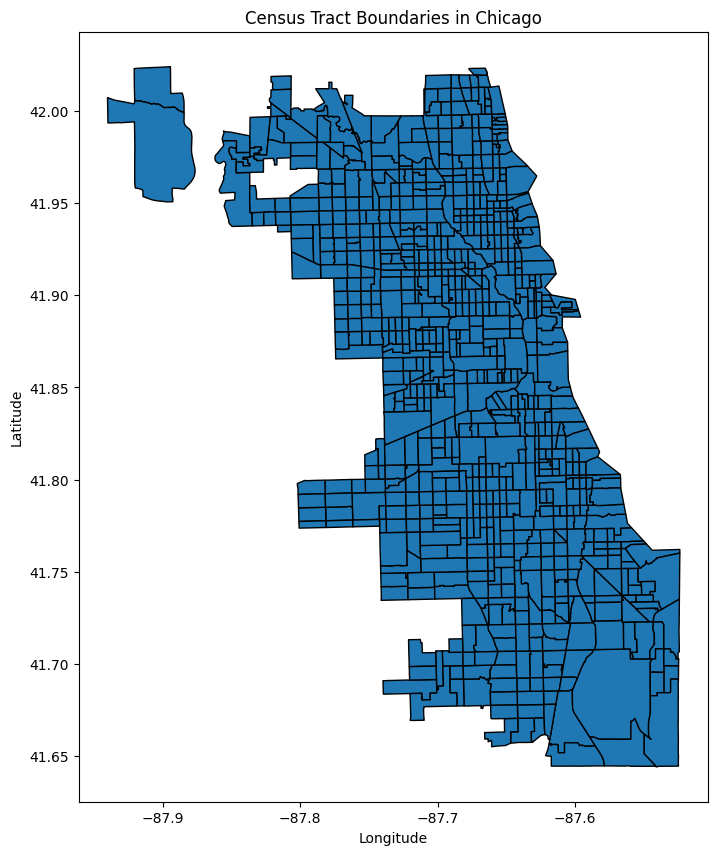

C:\Users\Adrian\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,trip_id,taxi_id,start_time,end_time,minutes,miles,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,...,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,temperature,wind_speed,precip,condition,pickup_census_tract_id
0,bcfa19f2539021c054809d4c3993d226996ae095,368ce5511598af2cc07efdb68067d381174fdac1d47a28...,2022-01-01 00:00:00,2022-01-01 00:00:00,2.53,0.10,NaN,NaN,NaN,3.75,...,NaN,NaN,NaN,NaN,NaN,33,21.0,0.0,Light Snow / Windy,<NA>
1,2aba69ff015f9ea8e7bff43cab7eddb228f34a12,449fa4909552757130d09d98ebc7770e2dd94579036b0e...,2022-01-01 00:00:00,2022-01-01 00:30:00,39.33,17.44,NaN,NaN,8.0,47.75,...,NaN,NaN,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),33,21.0,0.0,Light Snow / Windy,<NA>
2,54d812a0b88f8f9707825261014b3563a0a60ace,f98ae5e71fdda8806710af321dce58002146886c013f41...,2022-01-01 00:00:00,2022-01-01 00:00:00,8.93,4.83,NaN,28.0,22.0,14.75,...,-87.663518,POINT (-87.6635175498 41.874005383),41.922761,-87.699155,POINT (-87.6991553432 41.9227606205),33,21.0,0.0,Light Snow / Windy,91
3,040caea96573c5743668b138011bc157c7825e86,b9a58663518c48b09e83f462ca25ee0d702a2e4bc12199...,2022-01-01 00:00:00,2022-01-01 00:15:00,20.93,13.29,NaN,76.0,NaN,34.00,...,-87.913625,POINT (-87.913624596 41.9802643146),NaN,NaN,NaN,33,21.0,0.0,Light Snow / Windy,679
4,0f0c856e620e6b4dfd2bb1e921d966dd179eeca1,b21050ab3ad3d0972fd6378f6bf4d0251a8a7af42e6e0e...,2022-01-01 00:00:00,2022-01-01 00:00:00,0.55,0.17,NaN,3.0,3.0,63.27,...,-87.655879,POINT (-87.6558787862 41.96581197),41.965812,-87.655879,POINT (-87.6558787862 41.96581197),33,21.0,0.0,Light Snow / Windy,251


In [12]:


# Copy to have separate frames for census and h3 spatial units
df_taxi_census = df_taxi.copy()

geojson_path = "./data/input/Boundaries - Census Tracts - 2010.geojson"
census_tracts = gpd.read_file(geojson_path)

census_tracts['census_tract_id'] = range(1, len(census_tracts) +1)

# Plotting to check data consistency
ax = census_tracts.plot(edgecolor='black', figsize=(10, 10))
plt.title("Census Tract Boundaries in Chicago")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

geometry = [Point(xy) for xy in zip(df_taxi_census['pickup_centroid_longitude'], df_taxi_census['pickup_centroid_latitude'])]
geo_df_taxi = gpd.GeoDataFrame(df_taxi_census, geometry=geometry, crs=census_tracts.crs)

joined_data = gpd.sjoin(geo_df_taxi, census_tracts, how="left", op="within")

df_taxi_census['pickup_census_tract'] = joined_data['census_tract_id']


df_taxi_census['pickup_census_tract_id'] = df_taxi_census['pickup_census_tract'].astype('Int64')
df_taxi_census.drop(columns=['pickup_census_tract'], inplace=True)
# Making sure we have a uniform NaN
df_taxi_census.loc[df_taxi_census['pickup_census_tract_id'].isnull(), 'pickup_census_tract_id'] = None

df_taxi_census.head()

#### Remove start census without any values

In [13]:
# Checking how many start outside of a cencus tract 
print(f'We have {df_taxi_census["pickup_census_tract_id"].isnull().sum()/len(df_taxi_census)*100}% of trips starting outside a census tract')

# 8% is fine, as we have more than enough trainig data
df_taxi_census.dropna(subset=['pickup_census_tract_id'], inplace=True)

We have 8.210896776269234% of trips starting outside a census tract


#### Creating the h3 references

Create h3 spaital system based on SPATIAL_RESOLUTION parameter and import all trips into h3 spatial system

In [14]:
# Entrypoint - decide here if we want to exclude trips that start outside the cencus tracts from training

# Change in GLOBALS (top of file) only!
if(BASE_H3_DATASET_ON_CENSUS_DATASET):
    df_taxi_h3 = df_taxi_census.copy()
else:
    df_taxi_h3 = df_taxi.copy()


lon = 'pickup_centroid_longitude'
lat = 'pickup_centroid_latitude'

# Add h3 reference to h3 data
df_taxi_h3["h3_hex_id_start"] = df_taxi_h3.apply(
    lambda row: h3.geo_to_h3(row[lat], row[lon], SPATIAL_RESOLUTION) if (row[lat] and row[lon]) else 0,
    axis=1
)

In [15]:
distinct_count = df_taxi_h3["h3_hex_id_start"].nunique()
print("Number of distinct values in h3_hex_id_start:", distinct_count)

census_tracts = df_taxi_h3["pickup_census_tract_id"].nunique()
print("Number of distinct census tracts:", census_tracts)

Number of distinct values in h3_hex_id_start: 26
Number of distinct census tracts: 422


#### Adding the 'distance to center' feature
As we have already identified in the clustering there is higher demand the closer we are to the city center. Therefore, we add a spatial variable called distance_to_city_center, denoting the distance between the center of the polygon and the geographical city center of chicago. 

In [16]:
def calculate_distance(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Radius of the Earth in kilometers
    radius = 6371
    # Calculate the distance
    distance = radius * c
    
    # if the first coordinate is south of the second one, negate the distance
    if lat1 < lat2:
        distance *=-1

    return distance

# City center location:
center_lat = 41.879519
center_lon = -87.633026



#### Creating the demand X Spatial Unit dataframes for H3 and Census Resolution

For both census and h3 we do the following: For each spatial cell, we calculate the demand (number of starting trips) within the temporal resoultion of TIME_RESOLUTION (could be 1 hour,2, hours..)

In [17]:
def calculate_hourly_demand(input_dataframe, census_tract_column):
    input_df = input_dataframe.copy()
    input_df['start_time'] = pd.to_datetime(input_df['start_time'])
    
    result_data = []

    start_time_min = input_df['start_time'].min().replace(minute=0, second=0)
    start_time_max = input_df['start_time'].max().replace(minute=0, second=0) + pd.Timedelta(hours=1)
    
    time_range = pd.date_range(start=start_time_min, end=start_time_max, freq=TIME_RESOLUTION)
    df_time_range = pd.DataFrame({'start_time': time_range})
    
    # Iterate through unique census tract IDs
    unique_census_tracts = input_df[census_tract_column].unique()
    for census_tract in unique_census_tracts:
        temp_df = input_df[input_df[census_tract_column] == census_tract]
        temp_resampled = temp_df.resample(TIME_RESOLUTION, on='start_time').size().reset_index(name='demand')
        
        # Merge the two DataFrames to ensure all time steps are included
        temp_resampled = df_time_range.merge(temp_resampled, on=['start_time'], how='left').fillna(0)
        temp_resampled['spatial_unit_id'] = census_tract

        result_data.append(temp_resampled)
    
    # Concatenate the result dataframes
    result_df = pd.concat(result_data, ignore_index=True)
    
    return result_df

# caluclating demand for cencus and h3, roughly 2 min per Dataset on Adrians machine
df_demand_census = calculate_hourly_demand(df_taxi_census, 'pickup_census_tract_id')
df_demand_h3 = calculate_hourly_demand(df_taxi_h3, 'h3_hex_id_start')

In [18]:
df_demand_h3.info()
df_demand_census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516 entries, 0 to 9515
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   start_time       9516 non-null   datetime64[ns]
 1   demand           9516 non-null   float64       
 2   spatial_unit_id  9516 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 223.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154452 entries, 0 to 154451
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   start_time       154452 non-null  datetime64[ns]
 1   demand           154452 non-null  float64       
 2   spatial_unit_id  154452 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 3.5 MB


## Transformation Functions


In [19]:
def encode_cyclical_feature_inplace(df, column_name, period):
    """
    Encode a cyclical feature using sine and cosine functions and modify the original DataFrame inplace.
    
    Parameters:
        df (DataFrame): The DataFrame containing the cyclical feature to be encoded.
        column_name (str): The name of the column to be encoded.
        period (float): The period of the cyclic feature (e.g., 24 for hours, 12 for months).
    """
    radians = 2 * np.pi * df[column_name] / period
    df[f'{column_name}_sin'] = np.sin(radians)
    df[f'{column_name}_cos'] = np.cos(radians)

### Event Features
Events such as public holidays or federal holidays might influence the demand. In order to capture these patterns we introduce an additional feature. Holidays in 2022 (from https://www.officeholidays.com/countries/usa/illinois/2022):

- Jan 01: New Years Day
- Jan 17: Martin Luther King Jr. Day
- Feb 21: Presidents Day
- May 30: Memorial Day
- Jun 19: Juneteenth
- Jul 04: Independence Day
- Sep 05: Labor Day
- Oct 10: Columbus Day
- Nov 11: Veterans Day
- Nov 24: Thanksgiving
- Nov 25: Day after Thanksgiving
- Dec 25: Christmas Day
- Dec 26: Christmas Day in lieu 

In [20]:
holiday_dates = [datetime(2022, 1, 1), datetime(2022, 1, 17), datetime(2015, 2, 21), datetime(2022, 5, 30),
                 datetime(2022, 6, 19), datetime(2022, 7, 4), datetime(2022, 9, 5), datetime(2022, 10, 10),
                 datetime(2022, 11, 11), datetime(2022, 11, 24), datetime(2022, 11, 25), datetime(2022, 12, 25), datetime(2022, 12, 26)]

def feature_public_holiday(inputDataframe):
    inputDataframe['public_holiday'] = inputDataframe['start_time'].apply((lambda x: 1 if x in holiday_dates else 0))

### Season
The time demand pattern analysis has also shown that demand changes depending on the season, especially in summer months demand is high while demand is low during winter. Hence we construct a feature for each season.

In [21]:
# 1 = winter, 2 = Sprint, 3 = Fall  4 = Winter
def determine_season(date):
    if datetime(2022, 12, 22) <= date or date < datetime(2022, 3, 20):
        return 1
    elif datetime(2022, 3, 20) <= date < datetime(2022, 6, 21):
        return 2
    elif datetime(2022, 6, 21) <= date < datetime(2022, 9, 23):
        return 3
    else:
        return 4

def feature_season(inputDataframe):
    inputDataframe['season'] = inputDataframe['start_time'].apply(determine_season)
    encode_cyclical_feature_inplace(inputDataframe, 'season', 4)

### Weekend feature
In the descriptive analysis we have seen that on saturday and sunday the demand differs from weekday demand, hence we engineer a feature "weekend" which is 1 for all rides on saturday & sunday and zero for all other days.

In [22]:
def feature_weekend(inputDataframe):
    inputDataframe['weekend'] = inputDataframe['start_time'].apply(lambda x: 1 if x.weekday() >= 5 else 0)

### Hour Feature
The descriptive analysis has shown that the hour of the day servers as a good predictor for the demand. Hence we extract the hours of every timestamp.

In [23]:
# Extract date and time features

def feature_hour(inputDataframe):
    inputDataframe['hour'] = inputDataframe['start_time'].dt.hour
    encode_cyclical_feature_inplace(inputDataframe, 'hour', 24)

### Lagging Demand Features
As we have given time series data, it is a common approach to use the demand of previous hours (or days etc.) as an input for the prediction. The assumption we hereby make is that the factors that influence the demand have not changed dramatically within the used time frames. We have decided to construct the following features from previous demand:

2 hour: The asssumption is that the demand should not change dramatically between three hours. We assume we can not use the demand of the previous hour, as we want to construct a predictive system that can be fed with new data and has a computing time > 0. If we were to use the demand of the previous hour, even in a perfect world where the data would be available for prediction without any delay, we could not have a prediction about the coming demand before the predicted timeframe has already begun. 
24 hours: The asssumption is that the current demand should be comparable to the demand exactly one day ago, as factors such as season, time of the day are the same.

In [24]:
def feature_demand_lag(demand_dataframe):
    demand_dataframe['demand_h-2'] = demand_dataframe.demand.shift(periods=2)
    demand_dataframe['demand_h-24'] = demand_dataframe.demand.shift(periods=24)

### Weather Feature
We will add the hourly weather that was previously scraped from wunderground.

In [25]:
weather_dataframe = pd.read_csv('data/prepared/weather_data_2022_60min.csv')
weather_dataframe['date_time'] = pd.to_datetime(weather_dataframe['date_time'])

def merge_weather(demand_dataframe):

    demand_dataframe_unique = demand_dataframe.drop_duplicates(subset=['start_time'])
    merged_unique_df = demand_dataframe_unique.merge(weather_dataframe, left_on='start_time', right_on='date_time')
    
    # Forward-fill missing values in the specified columns
    columns_to_fill = ['temperature','wind_speed','precip']  
    merged_unique_df[columns_to_fill] = merged_unique_df[columns_to_fill].ffill()

    # Select columns from the right dataframe that do not exist in the demand dataframe
    new_columns = [col for col in merged_unique_df.columns if col not in demand_dataframe.columns]
    new_weather_columns = pd.DataFrame(merged_unique_df[new_columns].assign(start_time=merged_unique_df['start_time']))
    
    demand_dataframe = demand_dataframe.merge(new_weather_columns, on='start_time', how='left')
    return demand_dataframe

### Apply features
We will now apply all the features to the two dataframes

In [26]:
# Adding copy checkpoint as we are merging
df_h3 = df_demand_h3.copy()
df_census = df_demand_census.copy()

def apply_features(dataframe):
    feature_demand_lag(dataframe)
    feature_hour(dataframe)
    feature_weekend(dataframe)
    feature_season(dataframe)
    feature_public_holiday(dataframe)

apply_features(df_h3)
apply_features(df_census)

df_demand_h3_merged = merge_weather(df_h3)
df_demand_census_merged = merge_weather(df_census)

#### Last Cleanup
Checking both datasets and cleaning up last impurities, unnecesarry columns, missing values or missing encodings

In [27]:
# Due to the lag demand feature, we will loose 24h of data, but we have a lots of other days
def finalCleanup(dataframe):
    dataframe.drop(columns=['date_time', 'condition'], inplace=True)
    dataframe.dropna(inplace=True)

finalCleanup(df_demand_h3_merged)
finalCleanup(df_demand_census_merged)

,start_time,demand,spatial_unit_id,demand_h-2,demand_h-24,hour,hour_sin,hour_cos,weekend,season,season_sin,season_cos,public_holiday,date_time,temperature,wind_speed,precip,condition
24,2022-01-25,567.0,91,331.0,329.0,0,0.0,1.0,0,1,1.0,6.123234e-17,0,2022-01-25,7.0,10.0,0.0,Fair
25,2022-01-26,621.0,91,530.0,337.0,0,0.0,1.0,0,1,1.0,6.123234e-17,0,2022-01-26,-3.0,5.0,0.0,Fair
26,2022-01-27,669.0,91,567.0,495.0,0,0.0,1.0,0,1,1.0,6.123234e-17,0,2022-01-27,22.0,15.0,0.0,Cloudy
27,2022-01-28,640.0,91,621.0,553.0,0,0.0,1.0,0,1,1.0,6.123234e-17,0,2022-01-28,24.0,10.0,0.0,Light Snow
28,2022-01-29,496.0,91,669.0,526.0,0,0.0,1.0,1,1,1.0,6.123234e-17,0,2022-01-29,13.0,8.0,0.0,Cloudy


In [ ]:
df_demand_h3_merged.to_csv(f'{OUTPUT_FILENAME_BASE}_h3.csv', index=False)
df_demand_census_merged.to_csv(f'{OUTPUT_FILENAME_BASE}_census.csv', index=False)